In [68]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating project at `c:\Users\zsqu4re\Desktop\OCRL\Optimal-Control-and-Reinforcement-Learning\HW1_S25`


# Q3 (31 pts): Log-Domain Interior Point Quadratic Program Solver

Here we are going to use the log-domain interior point method described in Lecture 5 to create a QP solver for the following general problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\text{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \geq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.

We'll first walk you through the steps to reformulate the problem into an interior point log-domain form that we can solve.

## Part (A): KKT Conditions (2 pts)
**TASK**: Introduce Lagrange multipliers $\mu$ for the equality constraint, and $\lambda$ for the inequality constraint and fill in the following for the KKT conditions for the QP. For complementarity use the $\circ$ symbol (i.e. $a \circ b = 0$)

$$\begin{align}
Qx + q + A^{T}\mu - G^{T}\lambda &= 0 \quad \quad \text{(stationarity)} \\
Ax - b &= 0 \quad \quad \text{(primal feasibility)} \\
Gx - h &\geq 0 \quad \quad \text{(primal feasibility)} \\
\lambda &\geq 0 \quad \quad \text{(dual feasibility)} \\
\lambda \circ (Gx - h)  &= 0 \quad \quad \text{(complementarity)} 
\end{align}$$

## Part (B): Relaxed Complementarity (2 pts)

In order to apply the log-domain trick, we can introduce a slack variable to represent our inequality constraints ($s$). This new variable lets us enforce the inequality constraint ($s \geq 0$) by using a log-domain substitution which is always positive by construction. 

We'll also relax the complementarity condition as shown in class.

**TASK**: Modify your KKT conditions by doing the following:
1. Add a slack variable to split the primal feasibility $Gx - h \geq 0$ condition into $Gx - h = s$ and $s \geq 0$
2. Relax the complementarity condition so $\lambda \circ s = 0$ becomes $\lambda \circ s = 1^T\rho$ where $\rho$ will be some positive barrier parameter and $1$ is a vector of ones.

Write down the KKT conditions (there should now be six) after you've done the above steps.

$$\begin{align}
Qx + q + A^{T}\mu - G^{T}\lambda &= 0 \quad \quad \text{(stationarity)} \\
Ax - b &= 0 \quad \quad \text{(primal feasibility)} \\
Gx - h - s &=  0 \quad \quad \text{(primal feasibility)} \\
s &\geq 0 \quad \quad \text{(inequality contraint)} \\
\lambda &\geq 0 \quad \quad \text{(dual feasibility)} \\
\lambda \circ s &= 1^{T} \rho \quad \quad \text{(complementarity)} 

\end{align}$$

## Part (C): Log-domain Substitution (2 pts)

Finally, to enforce positivity on both $\lambda$ and $s$, we can perform a variable substitution. By using a particular substitution $\lambda = \sqrt\rho e^{-\sigma}$ and $s = \sqrt\rho e^\sigma$ we can also make sure that our relaxed complementarity condition $\lambda \circ s = 1^T\rho$ is always satisfied. 

**TASK**: Finally do the following:
1. Define a new variable $\sigma$ and define $\lambda = \sqrt\rho e^{-\sigma}$ and $s = \sqrt\rho e^\sigma$. 
2. Replace $\lambda$ and $s$ in your KKT conditions with the new definitions

Three of your KKT conditions from (B) should now be satisfied by construction. Write down the remaining 3 KKT conditions (hint: they should all be $=0$ and the only variables should be x, $\mu$, and $\sigma$).

$$\begin{align}
Qx + q + A^{T}\mu  - G^{T}\sqrt \rho e^{-\sigma} &= 0 \quad \quad \text{(stationarity)} \\
Ax - b &= 0 \quad \quad \text{(primal feasibility)} \\
Gx - h - \sqrt(\rho)e^{\sigma} &=  0 \quad \quad \text{(primal feasibility)} \\
\end{align}$$

## Part (D): Log-domain Interior Point Solver
We can now write our solver! You'll implement two residual functions (matching your residuals in Part A and C), and a function to solve the QP using Newton's method. The solver should work according to the following pseudocode where:
- $\rho$ is the barrier parameter
- kkt_conditions is the KKT conditions from part A
- ip_kkt_conditions is the KKT conditions from part C

```
rho = 0.1 (penalty parameter) 
for max_iters
    calculate the Newton step using ip_kkt_conditions and ip_kkt_jac
    perform a linesearch (use the same condition as in Q2, with the norm of the ip_kkt_conditions as the merit function)
    if norm(ip_kkt_conditions, Inf) < tol, update the barrier parameter
        rho = rho * 0.1
    end
    if norm(kkt_conditions, Inf) < tol
        exit
    end
end
```

In [69]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h, xi, μi, σi = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following functions where z = [x; μ; σ], λ = sqrt(ρ).*exp.(-σ), and s = sqrt(ρ).*exp.(σ)
    
    kkt_res = kkt_conditions(qp, z, ρ)   
    ip_res = ip_kkt_conditions(qp, z)
    ip_jac = ip_kkt_jacobian(qp, z)
    x, μ, λ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

"""

# Helper functions (you can use or not use these)
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

"""
    kkt_res = kkt_conditions(qp, z, ρ)

Return the KKT residual from part A as a vector (make sure to clamp the inequalities!)
In Julia, use the following for elementwise min.
elementwise_min = min.(a, b) # This is elementwise min
scalar_elementwise_min = min.(a, 0) # You can also take an elementwise min with a scalar
"""
function kkt_conditions(qp::NamedTuple, z::Vector, ρ::Float64)::Vector
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO compute λ from σ and ρ
    λ = sqrt(ρ).*exp.(-σ)

    # TODO compute and return KKT conditions
    stationarity = qp.Q * x + qp.q + qp.A' * μ - qp.G' * λ
    primal_feasibility_eq = c_eq(qp, x)
    primal_feasibility_ineq = min.(h_ineq(qp, x),0)
    dual_feasibility = min.(λ, 0)
    complementary = λ .* h_ineq(qp,x)

    # Combine all conditions into a single vector
    kkt_res = [stationarity; primal_feasibility_eq; primal_feasibility_ineq; dual_feasibility; complementary]
    return kkt_res 
end


"""
    ip_res = ip_kkt_conditions(qp, z)

Return the interior point KKT residual from part C as a vector
"""
function ip_kkt_conditions(qp::NamedTuple, z::Vector, ρ::Float64)::Vector
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO compute λ and s from σ and ρ
    λ = sqrt(ρ) .* exp.(-σ)
    s = sqrt(ρ) .* exp.(σ)

    # TODO compute and return IP KKT conditions

    stationarity = qp.Q * x + qp.q + qp.A' * μ - qp.G' * λ
    primal_feasibility_eq1 = c_eq(qp, x)
    primal_feasibility_eq2 = h_ineq(qp,x) - s
    return [stationarity; primal_feasibility_eq1; primal_feasibility_eq2]

end

"""
    ip_jac = ip_jacobian(qp, z, ρ)

Return the full Newton jacobian of the interior point KKT conditions (part C) with respect to z
Construct it analytically (don't use auto differentiation)
"""
function ip_kkt_jac(qp::NamedTuple, z::Vector, ρ::Float64)::Matrix
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO: return full Newton jacobian (don't use ForwardDiff)
    λ = sqrt(ρ).*exp.(-σ)
    s = sqrt(ρ).*exp.(σ)
    
    ∇²L = qp.Q

    ∇c = qp.A 
    ∇h = qp.G
    J = [qp.Q qp.A' qp.G'*Diagonal(λ); 
        qp.A zeros(length(μ),length(μ)) zeros(length(μ),length(σ)); 
        qp.G zeros(length(μ),length(σ))' -Diagonal(s)]

    return J
end


function logging(qp::NamedTuple, main_iter::Int, z::Vector, ρ::Real, α::Real)
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO: compute λ
    λ = sqrt(ρ) .* exp.(-σ)

    # TODO: stationarity norm
    stationarity_norm = norm(qp.Q * x + qp.q + qp.A' * μ - qp.G' * λ)
    
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e  %5.0e\n",
          main_iter, stationarity_norm, minimum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(λ,h_ineq(qp,x))), ρ, α)
end

"""
    x, μ, λ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

Solve the QP using the method defined in the pseudocode above, 
where z = [x; μ; σ], λ = sqrt(ρ).*exp.(-σ), and s = sqrt(ρ).*exp.(σ)
"""
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    # Init solution vector z = [x; μ; σ]
    z = zeros(length(qp.q) + length(qp.b) + length(qp.h))

    if verbose
        @printf "iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α\n"
        @printf "----------------------------------------------------------------\n"
    end

    # TODO: implement your solver according to the above pseudocode
    ρ = 0.1 #(penalty parameter) 

    # calculate the Newton step using ip_kkt_conditions and ip_kkt_jac
    # perform a linesearch (use the same condition as in Q2, with the norm 
    # of the ip_kkt_conditions as the merit function)

    for main_iter = 1:max_iters 
        
        c = kkt_conditions(qp, z, ρ)

        R = ip_kkt_conditions(qp, z, ρ)
        Δz = -ip_kkt_jac(qp, z, ρ) \ R

        α = 1.0
        for i = 1:max_iters
            if norm(ip_kkt_conditions(qp, z + α * Δz, ρ), Inf) < norm(ip_kkt_conditions(qp, z, ρ), Inf)
                break
            end
            α *= 0.5
        end

        z += α * Δz

        # TODO: make sure to save the step length (α) from your linesearch for logging

        if verbose
            logging(qp, main_iter, z, ρ, α) 
        end

        # TODO: convergence criteria based on tol
        if norm(kkt_conditions(qp, z, ρ), Inf) < tol
            x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]
            λ = sqrt(ρ) .* exp.(-σ)
            return x, μ, λ
        end
        
        if norm(ip_kkt_conditions(qp, z, ρ), Inf) < tol
            ρ *= 0.1
        end
    end
    
end

solve_qp

### QP Solver test

In [70]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(kkt_conditions(qp, qp_solutions.z, qp_solutions.ρ))<1e-3;
    @test norm(ip_kkt_conditions(qp, qp_solutions.z, qp_solutions.ρ))<1e-3;
    @test norm(ip_kkt_jac(qp, qp_solutions.z, qp_solutions.ρ) - FD.jacobian(dz -> ip_kkt_conditions(qp, dz, qp_solutions.ρ), qp_solutions.z), Inf) < 1e-3
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α
----------------------------------------------------------------
  1   5.13e+00  -3.51e-01   8.88e-16   6.94e-01  1e-01  1e+00
  2   1.14e+00   6.08e-02   4.44e-16   3.80e-01  1e-01  1e+00
  3   1.16e-01   8.52e-02   1.78e-15   4.52e-01  1e-01  1e+00
  4   5.60e-03   9.01e-02   3.33e-16   4.90e-01  1e-01  1e+00
  5   4.43e-04   9.03e-02   6.66e-16   4.99e-01  1e-01  1e+00
  6   1.23e-06   9.03e-02   3.33e-16   5.00e-01  1e-01  1e+00
  7   7.40e-12   9.03e-02   1.78e-15   5.00e-01  1e-01  1e+00
  8   5.34e-01   3.03e-02   8.88e-16   9.05e-02  1e-02  5e-01
  9   2.25e-02   9.16e-03   8.88e-16   4.93e-02  1e-02  1e+00
 10   1.20e-04   9.28e-03   8.88e-16   5.00e-02  1e-02  1e+00
 11   1.08e-08   9.28e-03   8.88e-16   5.00e-02  1e-02  1e+00
 12   2.83e-01   2.98e-03   8.88e-16   8.59e-03  1e-03  5e-01
 13   9.83e-03   9.35e-04   8.88e-16   4.93e-03  1e-03  1e+00
 14   1.88e-05   9.40e-04   8.88e-16   5.00e-03  1e-03  1e+00
 15   2

Test.DefaultTestSet("qp solver", Any[], 6, false, false, true, 1.738870613199e9, 1.738870616755e9, false, "In[70]")

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \mu \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\mu \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \mu_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\mu_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\mu_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (E): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && J(q_k + \Delta t \cdot v_{k+1}) \geq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**
$$\begin{align}
M v_{k+1} + M(\Delta t\cdot g - v_{k}) - \Delta t J^T \lambda &= 0 \quad \quad \text{(stationarity)} \\
J(q_k + \Delta t \cdot v_{k+1}) &= 0 \quad \quad \text{(primal feasibility)} \\
\lambda &\geq 0 \quad \quad \text{(dual feasibility)} \\
\lambda^T J(q_k + \Delta v_{k+1}) &= 0 \quad \quad \text{(Complementarity)}
\end{align}$$

## Part (F): Brick Simulation (5 pts)

In [71]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    
    g = [0.0;9.81]
    M = mass * Matrix{Float64}(I(2))
    J = [0 1] 
    

    qp = (
        Q = M,
        q = M*(Δt*g-v),
        A = zeros(0,2), # don't edit this
        b = zeros(0),   # don't edit this 
        G = Δt * J,
        h = -J * q,
        xi = 1:2,       # don't edit this
        μi = [],        # don't edit this
        σi = 3:3        # don't edit this
    )
    
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [72]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 .01]) < 1e-10 
    @test abs(qp.h[1] - -3) < 1e-10
    
end

Test Summary: | Pass  Total  Time
brick qp      |   10     10  0.1s


Test.DefaultTestSet("brick qp", Any[], 10, false, false, true, 1.738870616846e9, 1.738870616902e9, false, "In[72]")

#= In[75]:33 =# @test(abs(maximum(ys) - 2) < 0.1) = Test Passed
#= In[75]:34 =# @test(minimum(ys) > -0.01) = Test Passed
#= In[75]:35 =# @test(abs(xs[end] - 3) < 0.01) = Test Passed
#= In[75]:38 =# @test(maximum(xdot) < 1.0001) = Test Passed
#= In[75]:39 =# @test(minimum(xdot) > 0.9999) = Test Passed
#= In[75]:40 =# @test(ys[110] > 0.01) = Test Passed
#= In[75]:41 =# @test(abs(ys[111]) < 0.01) = Test Passed
#= In[75]:42 =# @test(abs(ys[112]) < 0.01) = Test Passed


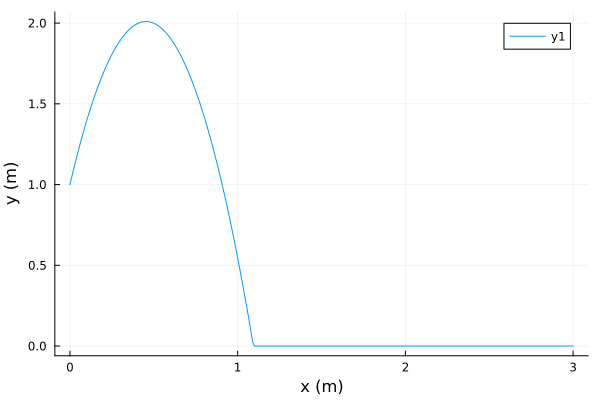

[ Info: Listening on: 127.0.0.1:8705, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8705


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8705, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8705), "127.0.0.1", "8705", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000000f64) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00000282ac66c5e0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 140713616255952, 4627172559694477643))), MeshCat.AnimationContext[]))

In [75]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]

    for k = 1:N-1
        qp = brick_simulation_qp(qs[k], vs[k])
        x, μ, λ = solve_qp(qp; verbose = false, max_iters = 150, tol = 1e-8)
        vs[k+1] = x
        qs[k+1] = qs[k] + dt * vs[k+1]
    end

    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end

# Part G (5 pts): Solve a QP

Use your QP solver to solve the following optimization problem:


$$
\begin{align} 
\min_{y\in\mathbb{R}^2,a\in\mathbb{R},b\in\mathbb{R}} \quad & \frac{1}{2}y^T \begin{bmatrix} 1 & .3 \\ .3 & 1 \end{bmatrix} y + a^2 + 2b^2  + \begin{bmatrix} -2 & 3.4 \end{bmatrix} y + 2a + 4b \\ 
\text{st} \quad & a + b = 1 \\ 
& \begin{bmatrix}-1 & 2.3 \end{bmatrix} y + a - 2b =3 \\
& -0.5 \leq y \leq 1 \\ 
& -1 \leq a \leq 1 \\ 
& -1 \leq b \leq 1
\end{align}
$$

You should be able to put this into our standard QP form that we used above, and solve.

In [88]:
@testset "part D" begin

    y = randn(2)
    a = randn()
    b = randn()
    
    #TODO: Create your qp and solve it. Don't forget the indices (xi, μi, and σi)
    qp = (
        Q = [1 0.3 0 0; 0.3 1 0 0; 0 0 2 0; 0 0 0 4],
        q = [-2; 3.4; 2; 4],
        A = [0 0 1 1; 
            -1 2.3 1 -2],
        b = [1; 3],
        G = [1 0 0 0; -1 0 0 0; 0 1 0 0; 0 -1 0 0; 0 0 1 0; 0 0 -1 0; 0 0 0 1; 0 0 0 -1],
        h = [1; 0.5; 1; 0.5; 1; 1; 1; 1],
        xi = 1:4,
        μi = 5:6,
        σi = 7:14
    )

    y,a,b= solve_qp(qp; verbose = false, max_iters = 200, tol = 1e-8)
    @show y,a,b 
    
    @test norm(y - [-0.080823; 0.834424]) < 1e-3 
    @test abs(a - 1) < 1e-3 
    @test abs(b) < 1e-3 
end

part D: Error During Test at In[88]:1
  Got exception outside of a @test
  MethodError: no method matching iterate(::Nothing)
  
  Closest candidates are:
    iterate(::Base.AsyncCollector, ::Base.AsyncCollectorState)
     @ Base asyncmap.jl:315
    iterate(::Base.AsyncCollector)
     @ Base asyncmap.jl:299
    iterate(::DataStructures.EnumerateAll)
     @ DataStructures C:\Users\zsqu4re\.julia\packages\DataStructures\95DJa\src\multi_dict.jl:98
    ...
  
  Stacktrace:
    [1] indexed_iterate(I::Nothing, i::Int64)
      @ Base .\tuple.jl:95
    [2] macro expansion
      @ In[88]:21 [inlined]
    [3] macro expansion
      @ C:\Users\zsqu4re\.julia\juliaup\julia-1.10.7+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Test\src\Test.jl:1577 [inlined]
    [4] top-level scope
      @ In[88]:3
    [5] eval
      @ .\boot.jl:385 [inlined]
    [6] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
      @ Base .\loading.jl:2139
    [7] softscope_include_strin

LoadError: [91mSome tests did not pass: 0 passed, 0 failed, 1 errored, 0 broken.[39m